# Training using REINFORCE for Mujoco

In [1]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym


plt.rcParams["figure.figsize"] = (10, 5)

### Policy Network

In [2]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16  # Nothing special with 16, feel free to change
        hidden_space2 = 32  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

### Building an agent

In [3]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-3  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        log_probs = torch.stack(self.probs)

        # Calculate the mean of log probabilities for all actions in the episode
        log_prob_mean = log_probs.mean()

        # Update the loss with the mean log probability and deltas
        # Now, we compute the correct total loss by taking the sum of the element-wise products.
        loss = -torch.sum(log_prob_mean * deltas)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

### Train the Policy

In [4]:
import os
os.environ['MUJOCO_GL'] = 'glfw'

In [5]:
# Create and wrap the environment
env = gym.make("InvertedPendulum-v5")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []
best_mean_reward = -np.inf
best_agent: REINFORCE | None = None

for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0 or episode == total_num_episodes - 1:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode+1, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

    mean_reward = np.mean(reward_over_episodes[-50:])
    if best_agent is None or mean_reward > best_mean_reward:
        best_mean_reward = mean_reward
        best_agent = agent

Episode: 1 Average Reward: 7
Episode: 1001 Average Reward: 73
Episode: 2001 Average Reward: 62
Episode: 3001 Average Reward: 115
Episode: 4001 Average Reward: 17
Episode: 5000 Average Reward: 18
Episode: 1 Average Reward: 18
Episode: 1001 Average Reward: 11
Episode: 2001 Average Reward: 9
Episode: 3001 Average Reward: 23
Episode: 4001 Average Reward: 14
Episode: 5000 Average Reward: 4
Episode: 1 Average Reward: 4
Episode: 1001 Average Reward: 30
Episode: 2001 Average Reward: 30
Episode: 3001 Average Reward: 45
Episode: 4001 Average Reward: 6
Episode: 5000 Average Reward: 47
Episode: 1 Average Reward: 47
Episode: 1001 Average Reward: 22
Episode: 2001 Average Reward: 37
Episode: 3001 Average Reward: 67
Episode: 4001 Average Reward: 83
Episode: 5000 Average Reward: 44
Episode: 1 Average Reward: 44
Episode: 1001 Average Reward: 38
Episode: 2001 Average Reward: 122
Episode: 3001 Average Reward: 194
Episode: 4001 Average Reward: 931
Episode: 5000 Average Reward: 951


### Plot learning curve

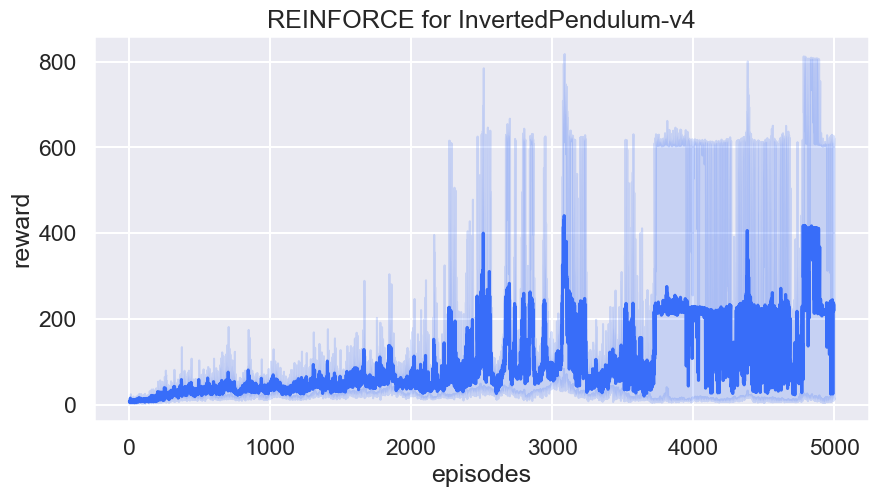

In [6]:
rewards_to_plot = rewards_over_seeds
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()

Best mean reward over the last 50 episodes (training): 951.16


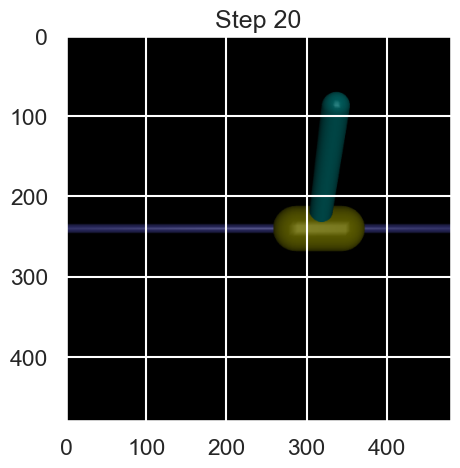

Reward for evaluation episode 1: 28


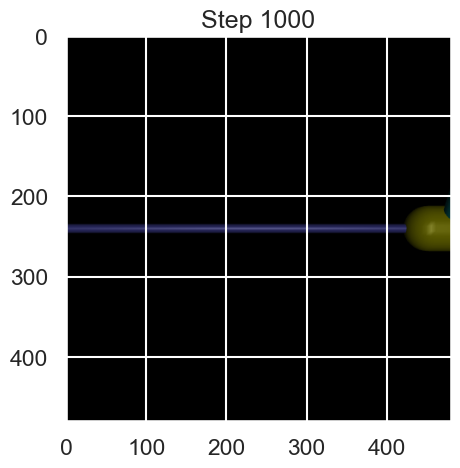

Reward for evaluation episode 2: 1000


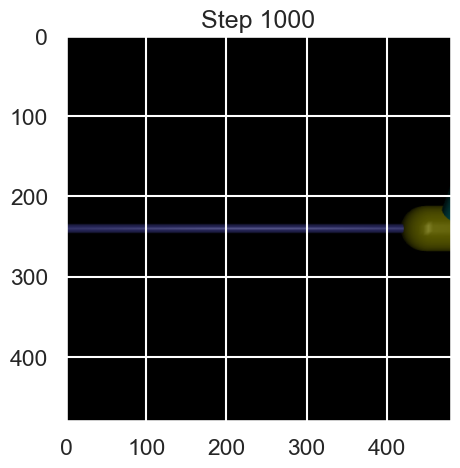

Reward for evaluation episode 3: 1000


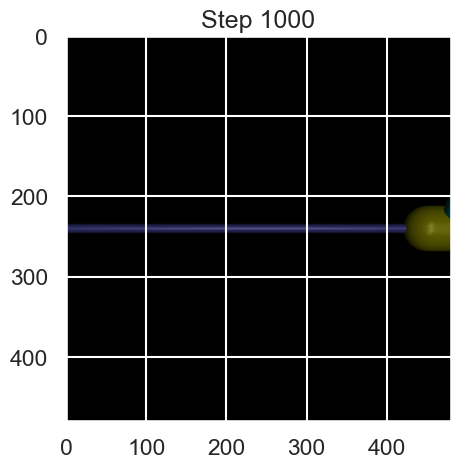

Reward for evaluation episode 4: 1000


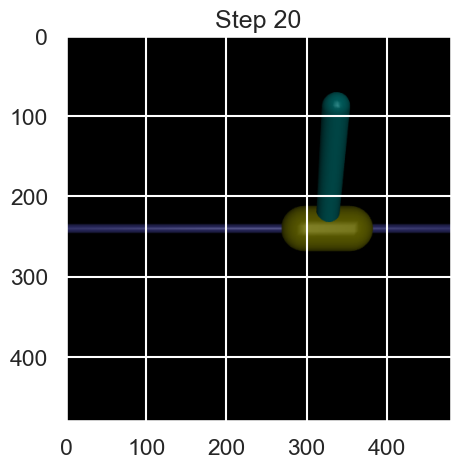

Reward for evaluation episode 5: 26


In [7]:
import time
from matplotlib import pyplot as plt
from gymnasium import Env
from IPython.display import display, update_display

class EnvRenderer:
    def render(self, env: Env):
        env.render()

    def reset(self):
        pass

class EnvImgRenderer(EnvRenderer):
    def __init__(self, render_every=1, wait=0.1):
        self.display_id: str | None = None
        self.step = 0
        self.render_every = render_every
        self.wait = wait

    def render(self, env: Env):
        if self.step % self.render_every != 0:
            self.step += 1
            return

        display_id = self.display_id

        plt.figure()

        # Render and display the new image
        plt.imshow(env.render())
        plt.title(f"Step {self.step}")

        if not display_id:
            dh = display(plt.gcf(), display_id=True)
            self.display_id = dh.display_id
        else:
            # Clear the previous rendered image
            update_display(plt.gcf(), display_id=display_id)

        plt.close()

        # Sleep for a short time to simulate the loop delay
        time.sleep(3 if not display_id else self.wait)

        self.step += 1

    def reset(self):
        self.display_id = None
        self.step = 0

def eval(render=True, limit=10000, seed=8):
    print(f'Best mean reward over the last 50 episodes (training): {best_mean_reward}')

    env = gym.make("InvertedPendulum-v5", render_mode="rgb_array")
    renderer = EnvImgRenderer(render_every=10) if render else None

    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    for i in range(5):
        obs, info = env.reset(seed=seed)
        done = False
        steps = 0
        total_reward = 0

        if renderer:
            renderer.reset()
            renderer.render(env)

        while not done and steps < limit:
            steps += 1
            action = best_agent.sample_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated

            if renderer:
                renderer.render(env)
        print(f"Reward for evaluation episode {i+1}: {total_reward}")

eval(render=True, limit=10000, seed=1)